In [1]:

import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np



import PIL
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LeakyReLU, BatchNormalization, ReLU, Activation
from tensorflow.keras.layers import UpSampling2D, Conv2D, Concatenate, Dense, concatenate, Conv2DTranspose
from tensorflow.keras.layers import Flatten, Lambda, Reshape, ZeroPadding2D, add
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.layers import Input, Flatten, Dense, Conv2D, BatchNormalization, LeakyReLU, Dropout, Activation
from keras.models import Model
from tensorflow.keras.utils import to_categorical
import keras.backend as K





In [13]:
# to get access to google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# for google drive case in colab

path = "/content/drive/MyDrive/gan"

Conditioning Augmentation Network

In [4]:
# conditioned by the text.
def conditioning_augmentation(x):
	"""The mean_logsigma passed as argument is converted into the text conditioning variable.

	Args:
		x: The output of the text embedding passed through a FC layer with LeakyReLU non-linearity.

	Returns:
	 	c: The text conditioning variable after computation.
	"""
	mean = x[:, :128]
	log_sigma = x[:, 128:]

	stddev = tf.math.exp(log_sigma)
	epsilon = K.random_normal(shape=K.constant((mean.shape[1], ), dtype='int32'))
	c = mean + stddev * epsilon
	return c

def build_ca_network():
	"""Builds the conditioning augmentation network.
	"""
	input_layer1 = Input(shape=(1024,)) #size of the vocabulary in the text data
	mls = Dense(256)(input_layer1)
	mls = LeakyReLU(alpha=0.2)(mls)
	ca = Lambda(conditioning_augmentation)(mls)
	return Model(inputs=[input_layer1], outputs=[ca])

Stage 1 Generator Network

In [5]:
def UpSamplingBlock(x, num_kernels, index=0):
	"""An Upsample block with Upsampling2D, Conv2D, BatchNormalization and a ReLU activation.

	Args:
		x: The preceding layer as input.
		num_kernels: Number of kernels for the Conv2D layer.

	Returns:
		x: The final activation layer after the Upsampling block.
	"""
  
	# x = Conv2DTranspose(num_kernels, kernel_size=(2,2), strides=(2,2))(x)

	x = UpSampling2D(size=(2,2))(x) # was originally
	x = Conv2D(num_kernels, kernel_size=(3,3), padding='same', strides=1, use_bias=False,
				kernel_initializer='he_uniform')(x)
	x = BatchNormalization(gamma_initializer='ones', beta_initializer='zeros')(x) #prevent from mode collapse
	x = LeakyReLU(alpha=0.2)(x) # ReLU(x)
	x = Dropout(0.5)(x) # custom
	return x


def build_stage1_generator():

	input_layer1 = Input(shape=(1024,))
	ca = Dense(256)(input_layer1)
	ca = LeakyReLU(alpha=0.2)(ca)

	# Obtain the conditioned text
	c = Lambda(conditioning_augmentation)(ca)

	input_layer2 = Input(shape=(100,))
	concat = Concatenate(axis=1)([c, input_layer2])

	x = Dense(16384, use_bias=False)(concat) 
	x = LeakyReLU()(x) # ReLU
	print(x.shape)
	x = Reshape((4, 4, 1024), input_shape=(16384,))(x)
 
	x = UpSamplingBlock(x, 512)
	x = UpSamplingBlock(x, 256)  # upsampled our image to 64*64*3 
	x = UpSamplingBlock(x, 128,index=1)  # upsampled our image to 64*64*3 
	x = UpSamplingBlock(x, 64, index=1)  # upsampled our image to 64*64*3 

	x = Conv2D(3, kernel_size=3, padding='same', strides=1, use_bias=False,
				kernel_initializer='he_uniform')(x)
	x = Activation('tanh')(x)

	stage1_gen = Model(inputs=[input_layer1, input_layer2], outputs=[x, ca]) 
	return stage1_gen



Stage 1 Discriminator Network

In [6]:
def ConvBlock(x, num_kernels, kernel_size=(4,4), strides=2, activation=True):
	"""A ConvBlock with a Conv2D, BatchNormalization and LeakyReLU activation.

	Args:
		x: The preceding layer as input.
		num_kernels: Number of kernels for the Conv2D layer.

	Returns:
		x: The final activation layer after the ConvBlock block.
	"""
	x = Conv2D(num_kernels, kernel_size=kernel_size, padding='same', strides=strides, use_bias=False,
				kernel_initializer='he_uniform')(x)
	x = BatchNormalization(gamma_initializer='ones', beta_initializer='zeros')(x)
	
	if activation:
		x = LeakyReLU(alpha=0.2)(x)
	return x


def build_embedding_compressor():

	"""Build embedding compressor model
	"""

	input_layer1 = Input(shape=(1024,))
	x = Dense(128)(input_layer1)
	x = LeakyReLU()(x) # ReLU


	model = Model(inputs=[input_layer1], outputs=[x])
	return model



# the discriminator is fed with two inputs, the feature from Generator and the text embedding
def build_stage1_discriminator():
	"""Builds the Stage 1 Discriminator that uses the 64x64 resolution images from the generator
	and the compressed and spatially replicated embedding.

	Returns:
		Stage 1 Discriminator Model for StackGAN.
	"""
	
	input_layer1 = Input(shape=(64, 64, 3))  

	x = Conv2D(64, kernel_size=(4,4), strides=2, padding='same', use_bias=False,
				kernel_initializer='he_uniform')(input_layer1)		
				
	x = LeakyReLU(alpha=0.2)(x)

	x = ConvBlock(x, 128)
	x = ConvBlock(x, 256)
	x = ConvBlock(x, 512)

	# Obtain the compressed and spatially replicated text embedding
	input_layer2 = Input(shape=(4, 4, 128)) #2nd input to discriminator, text embedding
	concat = concatenate([x, input_layer2])

	x1 = Conv2D(512, kernel_size=(1,1), padding='same', strides=1, use_bias=False,
				kernel_initializer='he_uniform')(concat)
	x1 = BatchNormalization(gamma_initializer='ones', beta_initializer='zeros')(x)
	x1 = LeakyReLU(alpha=0.2)(x)

	# Flatten and add a FC layer to predict.
	x1 = Flatten()(x1)
	x1 = Dense(1)(x1)
	x1 = Activation('sigmoid')(x1)

	stage1_dis = Model(inputs=[input_layer1, input_layer2], outputs=[x1])  
	return stage1_dis

Stage 1 Adversarial Model (Building a GAN)

In [7]:
# Building GAN with Generator and Discriminator

def build_adversarial(generator_model, discriminator_model):
	"""Stage 1 Adversarial model.

	Args:
		generator_model: Stage 1 Generator Model
		discriminator_model: Stage 1 Discriminator Model

	Returns:
		Adversarial Model.
	"""
	input_layer1 = Input(shape=(1024,))  
	input_layer2 = Input(shape=(100,)) 
	input_layer3 = Input(shape=(4, 4, 128)) 

	x, ca = generator_model([input_layer1, input_layer2]) #text,noise

	discriminator_model.trainable = False 

	probabilities = discriminator_model([x, input_layer3]) 
	adversarial_model = Model(inputs=[input_layer1, input_layer2, input_layer3], outputs=[probabilities, ca])
	return adversarial_model

# Train Utilities


In [8]:
# the loss function of completed model
import pickle

def adversarial_loss(y_true, y_pred):
	mean = y_pred[:, :128]
	ls = y_pred[:, 128:]
	loss = -ls + 0.5 * (-1 + tf.math.exp(2.0 * ls) + tf.math.square(mean))
	loss = K.mean(loss)
	return loss


def normalize(input_image, real_image):
	input_image = (input_image / 127.5) - 1
	real_image = (real_image / 127.5) - 1

	return input_image, real_image



def load_text_embeddings(text_embeddings):
    
		with open(text_embeddings, 'rb') as f:
			embeds = pickle.load(f)
		
		return embeds
    

# for girls dataset
def load_bbox(data_path):
	b_boxes_list = []
	
	with open(data_path) as file:
		for line in file:
			row = line.rstrip().split()
			b_boxes_list.append(row[1:])
	return b_boxes_list
    

def save_image(file, save_path):
	"""Saves the image at the specified file path.
	"""
	image = plt.figure()
	ax = image.add_subplot(1,1,1)
	ax.imshow(file)
	ax.axis("off")
	plt.savefig(save_path)


def load_data(dataset_path, embeddings_path):
	"""load dataset"""
	
	embeddings = load_text_embeddings(embeddings_path)
	x, embeds  = [],[]
	bbox_list = load_bbox(path+"/girls_dataset/bounding_boxes.txt")

	index = 0
	
	
	# girls dataset open .pickle filenames
	images_path = path+"/girls_dataset/Image/00_Female/"
	with open(dataset_path, 'rb') as f:
		images_names = pickle.load(f)
	
	for name in images_names:
		image_name = name[10:]+".png"
		# image_name = name.removeprefix("00_Female/")+".png"
		
		# load image from path
		image = Image.open(images_path+image_name)
		
		bounds_list_values = bbox_list[index]
		a = list(map(float, bounds_list_values))
		bounding_box = list(map(int, a))
		# crop image
		if bounding_box is not None:
			image = image.crop(bounding_box)
			
	
		image = image.resize((64,64), PIL.Image.BILINEAR)
		try:
			e = embeddings[index, :, :]
			x.append(np.array(image))
			embeds.append(e.reshape(-1))
			
		except Exception as e:
			print(f'{e}')
			
		# move to the next image and embed
		index+=1
		# if dataset_path == "train/" and index == 4500:
		# 	break
		# elif dataset_path == "test/" and index == 700:
		# 	break
	
	x = np.array(x)
	embeds = np.array(embeds)
	
	return x, embeds
	
	# for file_name in os.listdir(dataset_path):
		
	
	# 	# load image from path
	# 	image = Image.open(dataset_path+file_name)
		
	# 	bounds_list_values = bbox_list[index]
	# 	a = list(map(float, bounds_list_values))
	# 	bounding_box = list(map(int, a))
		
	# 	# crop image
	# 	if bounding_box is not None:
	# 		image = image.crop(bounding_box)
			
	
	# 	image = image.resize((64,64), PIL.Image.Resampling.BILINEAR)
	# 	try:
	# 		e = embeddings[index, :, :]
	# 		x.append(np.array(image))
	# 		embeds.append(e)
			
	# 	except Exception as e:
	# 		print(f'{e}')
			
	# 	# move to the next image and embed
	# 	index+=1
	# 	if dataset_path == "train/" and index == 4500:
	# 		break
	# 	elif dataset_path == "test/" and index == 700:
	# 		break
	
	# x = np.array(x)
	# embeds = np.array(embeds)
	
	# return x, embeds
	

In [ ]:

class StackGanStage1(object):
    

	def __init__(self, epochs=1000, z_dim=100, batch_size=64, enable_function=True, 
		stage1_generator_lr=0.0002, stage1_discriminator_lr=0.0002):

		

        # StackGAN hyperparameters
		self.epochs = epochs
		self.z_dim = z_dim
		self.enable_function = enable_function
		self.stage1_generator_lr = stage1_generator_lr
		self.stage1_discriminator_lr = stage1_discriminator_lr
		self.image_size = 64
		self.conditioning_dim = 128
		self.batch_size = batch_size

  

		# ADAM optimizer for both models of DIS and GEN
		self.stage1_generator_optimizer = Adam(learning_rate=stage1_generator_lr, beta_1=0.5, beta_2=0.999)
		self.stage1_discriminator_optimizer = Adam(learning_rate=stage1_discriminator_lr, beta_1=0.5, beta_2=0.999)
		# self.stage1_discriminator_optimizer = SGD(learning_rate=0.1, momentum=0.9)
			
        # create the generator model of 1st stage 
		self.stage1_generator = build_stage1_generator()
		self.stage1_generator.compile(loss='mse', optimizer=self.stage1_generator_optimizer)
		
		# load model weights after 150 epochs
		# self.stage1_generator.load_weights("weights/stage1_gen.h5")

        # create the discriminator model of 1st stage 
		self.stage1_discriminator = build_stage1_discriminator()
		self.stage1_discriminator.compile(loss='binary_crossentropy', 
                                    optimizer=self.stage1_discriminator_optimizer)
                                    
        # load model weights after 150 epochs
		# self.stage1_discriminator.load_weights("weights/stage1_disc.h5")
        
        # create the block(network) that perfoms Conditional Augmentation with embeddings 
		self.ca_network = build_ca_network()
		self.ca_network.compile(loss='binary_crossentropy', optimizer='Adam')
        
        # load model weights after 150 epochs
		# self.ca_network.load_weights("weights/stage1_ca.h5")
        
		self.embedding_compressor = build_embedding_compressor()
		self.embedding_compressor.compile(loss='binary_crossentropy', optimizer='Adam')
		
		# load model weights after 150 epochs
		# self.embedding_compressor.load_weights("weights/stage1_embco.h5")

        # create the completed GAN model 
		self.stage1_adversarial = build_adversarial(self.stage1_generator, self.stage1_discriminator)
  
		self.stage1_adversarial.compile(loss=['binary_crossentropy', adversarial_loss], 
                                  loss_weights=[1, 2.0], 
                                  optimizer=self.stage1_generator_optimizer)
                                  
        # load model weights after 150 epochs
		# self.stage1_adversarial.load_weights("weights/stage1_adv.h5")
         
         
		self.checkpoint1 = tf.train.Checkpoint(
				generator_optimizer=self.stage1_generator_optimizer,
				discriminator_optimizer=self.stage1_discriminator_optimizer,
				generator=self.stage1_generator,
				discriminator=self.stage1_discriminator)


	def train_stage1(self):
		"""Trains the stage1 StackGAN.
		"""
		
		
		
		# for girls dataset

		path = "/content/drive/MyDrive/gan"

		dataset_train_path = path+"/girls_dataset/Train/filenames.pickle"
		dataset_test_path =  path+"/girls_dataset/Test/filenames.pickle"
		embeddings_path_train_file = path+"/init_embedding_values_girls/embed_train.pickle"
		embeddings_path_test_file = path+"/init_embedding_values_girls/embed_test.pickle"
		
		x_train, train_embeds = load_data(dataset_path=dataset_train_path, embeddings_path=embeddings_path_train_file)

		x_test, test_embeds = load_data(dataset_path=dataset_test_path, embeddings_path=embeddings_path_test_file)
		
		print(len(x_test),len(test_embeds))
		print(len(x_train),len(train_embeds))
		
		print(x_test.shape,test_embeds.shape)
		print(x_train.shape,train_embeds.shape)
		

		real = np.ones((self.batch_size, 1), dtype='float') * 0.9
		fake = np.zeros((self.batch_size, 1), dtype='float') * 0.1

		for epoch in range(self.epochs):
			print(f'EPOCH: {epoch}')

			gen_loss = []
			dis_loss = []

			num_batches = int(x_train.shape[0] / self.batch_size)

			for i in range(num_batches):

				latent_space = np.random.normal(0, 1, size=(self.batch_size, self.z_dim))
				embedding_text = train_embeds[i * self.batch_size:(i + 1) * self.batch_size]
				compressed_embedding = self.embedding_compressor.predict_on_batch(embedding_text)
				compressed_embedding = np.reshape(compressed_embedding, (-1, 1, 1, 128))
				compressed_embedding = np.tile(compressed_embedding, (1, 4, 4, 1))

				image_batch = x_train[i * self.batch_size:(i+1) * self.batch_size]
				image_batch = (image_batch - 127.5) / 127.5

				gen_images, _ = self.stage1_generator.predict([embedding_text, latent_space])

				discriminator_loss = self.stage1_discriminator.train_on_batch([image_batch, compressed_embedding], 
						np.reshape(real, (self.batch_size, 1)))

				discriminator_loss_gen = self.stage1_discriminator.train_on_batch([gen_images, compressed_embedding],
						np.reshape(fake, (self.batch_size, 1)))

				discriminator_loss_wrong = self.stage1_discriminator.train_on_batch([gen_images[: self.batch_size-1], 
				compressed_embedding[1:]], 
						np.reshape(fake[1:], (self.batch_size-1, 1)))

				# Discriminator loss
				d_loss = 0.5 * np.add(discriminator_loss, 0.5 * np.add(discriminator_loss_gen, discriminator_loss_wrong))
				dis_loss.append(d_loss)
				
				print(f'Discriminator Loss: {d_loss}')

				# Generator loss
				g_loss = self.stage1_adversarial.train_on_batch([embedding_text, latent_space, compressed_embedding],
						[K.ones((self.batch_size, 1)) * 0.9, K.ones((self.batch_size, 256)) * 0.9])

				print(f'Generator Loss: {g_loss}')
				gen_loss.append(g_loss)

				if epoch % 5 == 0:
						latent_space = np.random.normal(0, 1, size=(self.batch_size, self.z_dim))
						embedding_batch = test_embeds[0 : self.batch_size]
						gen_images, _ = self.stage1_generator.predict_on_batch([embedding_batch, latent_space])

						for i, image in enumerate(gen_images[:10]):
							save_image(image, path+f'/image_test_result_stage_1/gen_1_{epoch}_{i}')

				# we trained weights up to 25 epoch so we start from 25
				# if epoch > 25:

				path = path+"/"
				if epoch % 25 == 0:
					self.stage1_generator.save_weights(path+'weights_stage_1/stage1_gen.h5')
					self.stage1_discriminator.save_weights(path+"weights_stage_1/stage1_disc.h5")
					self.ca_network.save_weights(path+'weights_stage_1/stage1_ca.h5')
					self.embedding_compressor.save_weights(path+'weights_stage_1/stage1_embco.h5')
					self.stage1_adversarial.save_weights(path+'weights_stage_1/stage1_adv.h5')  
		 
      # if gradient of gen is out of 100 each batch so then we finish training after 30 epochs 
			if epoch > 1 and np.sum(gen_loss) > 600:
				break 

		self.stage1_generator.save_weights(path+'weights_stage_1/stage1_gen.h5')
		self.stage1_discriminator.save_weights(path+"weights_stage_1/stage1_disc.h5")
    
    

In [20]:
def load_text_embeddings(text_embeddings):
    
		with open(text_embeddings, 'rb') as f:
			embeds = pickle.load(f)
		
		return embeds


def load_data_predict(embeddings_path):
  """load text"""

  embeddings = load_text_embeddings(embeddings_path)
  embeds  = []

  try:
    e = embeddings[0, :, :]
    embeds.append(e.reshape(-1))

  except Exception as e:
    print(f'{e}')


  embeds = np.array(embeds)

  return embeds
	

## **Predict the image**

In [61]:
import datetime



class StackGanStage1(object):
    

	def __init__(self, epochs=1000, z_dim=100, enable_function=True, 
		stage1_generator_lr=0.0002, stage1_discriminator_lr=0.0002):

	
    # StackGAN hyperparameters
		self.z_dim = z_dim
		self.batch_size = 1
		self.enable_function = enable_function
		self.stage1_generator_lr = stage1_generator_lr
		self.stage1_discriminator_lr = stage1_discriminator_lr
		self.image_size = 64
		self.conditioning_dim = 128

		path = "/content/drive/MyDrive/gan/"

  

		# ADAM optimizer for both models of DIS and GEN
		self.stage1_generator_optimizer = Adam(learning_rate=stage1_generator_lr, beta_1=0.5, beta_2=0.999)
		self.stage1_discriminator_optimizer = Adam(learning_rate=stage1_discriminator_lr, beta_1=0.5, beta_2=0.999)
		# self.stage1_discriminator_optimizer = SGD(learning_rate=0.1, momentum=0.9)
			
        # create the generator model of 1st stage 
		self.stage1_generator = build_stage1_generator()
		self.stage1_generator.compile(loss='mse', optimizer=self.stage1_generator_optimizer)
		
		# load model weights after 600 epochs
		self.stage1_generator.load_weights(path+"weights_stage_1/stage1_gen.h5")

        # create the discriminator model of 1st stage 
		self.stage1_discriminator = build_stage1_discriminator()
		self.stage1_discriminator.compile(loss='binary_crossentropy', 
                                    optimizer=self.stage1_discriminator_optimizer)
                                    
    # load model weights after 600 epochs
		self.stage1_discriminator.load_weights(path+"weights_stage_1/stage1_disc.h5")
        
    # create the block(network) that perfoms Conditional Augmentation with embeddings 
		self.ca_network = build_ca_network()
		self.ca_network.compile(loss='binary_crossentropy', optimizer='Adam')
        
    # load model weights after 600 epochs
		self.ca_network.load_weights(path+"weights_stage_1/stage1_ca.h5")
        
		self.embedding_compressor = build_embedding_compressor()
		self.embedding_compressor.compile(loss='binary_crossentropy', optimizer='Adam')
		
		# load model weights after 600 epochs
		self.embedding_compressor.load_weights(path+"weights_stage_1/stage1_embco.h5")

    # create the completed GAN model 
		self.stage1_adversarial = build_adversarial(self.stage1_generator, self.stage1_discriminator)
  
		self.stage1_adversarial.compile(loss=['binary_crossentropy', adversarial_loss], 
                                  loss_weights=[1, 2.0], 
                                  optimizer=self.stage1_generator_optimizer)
                                  
    # load model weights after 600 epochs
		self.stage1_adversarial.load_weights(path+"weights_stage_1/stage1_adv.h5")
         
        


	def predict_image_generation(self):
		"""Predict the image StackGAN.
		"""
		
		# for girls dataset

		path = "/content/drive/MyDrive/gan"

		embeddings_path_text_file = path+"/init_embedding_values_girls_predict/embed_text_predict.pickle"
		
		text_embeds = load_data_predict(embeddings_path=embeddings_path_text_file)
		

		real = np.ones((self.batch_size, 1), dtype='float') * 0.9
		fake = np.zeros((self.batch_size, 1), dtype='float') * 0.1

		latent_space = np.random.normal(0, 1, size=(self.batch_size, self.z_dim))
		embedding_text = text_embeds
		compressed_embedding = self.embedding_compressor.predict_on_batch(embedding_text)
		compressed_embedding = np.reshape(compressed_embedding, (-1, 1, 1, 128))
		compressed_embedding = np.tile(compressed_embedding, (1, 4, 4, 1))
	

		dt_now = str(datetime.datetime.now())
		print(dt_now)
		gen_images, _ = self.stage1_generator.predict([embedding_text, latent_space])
		save_image(gen_images[0], path+f'/prediction_result/predicted_image_{dt_now[:19]}')



(None, 16384)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2022-06-28 10:23:39.271463


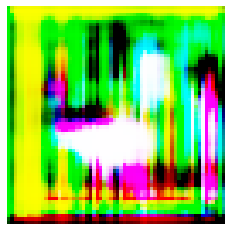

In [62]:
stage1 = StackGanStage1()
stage1.predict_image_generation()